
### [Fixed Income Examples]((https://pmorissette.github.io/bt/examples.html#:~:text=each%20transaction%20marked.-,Fixed%20Income%20Examples,-This%20example%20notebook))


In [1]:
import bt
import pandas as pd
from pandas.tseries.frequencies import to_offset
import numpy as np
import warnings

warnings.simplefilter(action="ignore")
np.random.seed(1234)
%matplotlib inline

### PVBP
- 채권의 가격이 금리가 1 베이시스 포인트(basis point, 0.01%) 변동할 때 얼마나 변하는지를 측정하는 지표
- 채권 가격의 금리 민감도를 나타내는 개념
- 금리 변동에 따른 채권의 가치 변화를 이해하는데 사용

In [2]:
# (Approximate) Price to yield calcs, and pvbp, for later use. Note we use clean price here.
def price_to_yield(p, ttm, coupon):
    """
    채권의 가격을 수익률로 변환
    - p: 채권의 가격 (clean price, 즉 누적 이자를 제외한 가격)
    - ttm: 만기까지 남은 기간 (time to maturity, 연 단위)
    - coupon: 연간 이자 지급액 (coupon rate, 퍼센트 단위)
    """
    return (coupon + (100.0 - p) / ttm) / ((100.0 + p) / 2.0) * 100


def yield_to_price(y, ttm, coupon):
    """
    채권의 수익률을 가격으로
    - y: 채권의 수익률 (yield, 퍼센트 단위)
    - ttm: 만기까지 남은 기간 (time to maturity, 연 단위)
    - coupon: 연간 이자 지급액 (coupon rate, 퍼센트 단위)
    """
    return (coupon + 100 / ttm - 0.5 * y) / (y / 200 + 1 / ttm)


def pvbp(y, ttm, coupon):
    """
    채권의 PVBP(Present Value of a Basis Point) 계산
    - y: 채권의 수익률 (yield, 퍼센트 단위)
    - ttm: 만기까지 남은 기간 (time to maturity, 연 단위)
    - coupon: 연간 이자 지급액 (coupon rate, 퍼센트 단위)
    """
    return yield_to_price(y + 0.01, ttm, coupon) - yield_to_price(y, ttm, coupon)

In [3]:
# Utility function to set data frame values to nan before the security has been issued or after it has matured
def censor(data: pd.DataFrame, ref_data):
    for bond in data:
        data.loc[
            (data.index > ref_data["mat_date"][bond])
            | (data.index < ref_data["issue_date"][bond]),
            bond,
        ] = np.NaN
    return data.ffill(
        limit=1, axis=0
    )  # Because bonds might mature during a gap in the index (i.e. on the weekend)

In [4]:
# Backtesting timeline setup
start_date = pd.Timestamp("2020-01-01")
end_date = pd.Timestamp("2022-01-01")
timeline = pd.date_range(start_date, end_date, freq="B")

In [5]:
# Government Bonds: Create synthetic data for a single series of rolling government bonds

# Reference Data
roll_freq = "Q"
maturity = 10
coupon = 2.0
roll_dates = pd.date_range(
    start_date, end_date + to_offset(roll_freq), freq=roll_freq
)  # Go one period beyond the end date to be safe
issue_dates = roll_dates - roll_dates.freq
mat_dates = issue_dates + pd.offsets.DateOffset(years=maturity)
series_name = "govt_10Y"
names = pd.Series(mat_dates).apply(lambda x: "govt_%s" % x.strftime("%Y_%m"))
# Build a time series of OTR
govt_otr = pd.DataFrame(
    [
        [name for name, roll_date in zip(names, roll_dates) if roll_date >= d][0]
        for d in timeline
    ],
    index=timeline,
    columns=[series_name],
)
# Create a data frame of reference data
govt_data = pd.DataFrame(
    {"mat_date": mat_dates, "issue_date": issue_dates, "roll_date": roll_dates},
    index=names,
)
govt_data["coupon"] = coupon

# Create the "roll map"
govt_roll_map = govt_otr.copy()
govt_roll_map["target"] = govt_otr[series_name].shift(-1)
govt_roll_map = govt_roll_map[govt_roll_map[series_name] != govt_roll_map["target"]]
govt_roll_map["factor"] = 1.0
govt_roll_map = (
    govt_roll_map.reset_index()
    .set_index(series_name)
    .rename(columns={"index": "date"})
    .dropna()
)

# Market Data and Risk
govt_yield_initial = 2.0
govt_yield_vol = 1.0
govt_yield = pd.DataFrame(columns=govt_data.index, index=timeline)
govt_yield_ts = (
    govt_yield_initial
    + np.cumsum(np.random.normal(0.0, govt_yield_vol / np.sqrt(252), len(timeline)))
).reshape(-1, 1)
govt_yield.loc[:, :] = govt_yield_ts

govt_mat = pd.DataFrame(columns=govt_data.index, index=timeline, data=pd.NA).astype(
    "datetime64[ns]"
)
govt_mat.loc[:, :] = govt_data["mat_date"].values.T
govt_ttm = (govt_mat - timeline.values.reshape(-1, 1)) / pd.Timedelta(days=365)
govt_coupon = pd.DataFrame(columns=govt_data.index, index=timeline)
govt_coupon.loc[:, :] = govt_data["coupon"].values.T
govt_accrued = govt_coupon.multiply(
    timeline.to_series().diff() / pd.Timedelta(days=365), axis=0
)
govt_accrued.iloc[0] = 0

govt_price = yield_to_price(govt_yield, govt_ttm, govt_coupon)
govt_price[govt_ttm <= 0] = 100.0
govt_price = censor(govt_price, govt_data)
govt_pvbp = pvbp(govt_yield, govt_ttm, govt_coupon)
govt_pvbp[govt_ttm <= 0] = 0.0
govt_pvbp = censor(govt_pvbp, govt_data)

In [6]:
# Corporate Bonds: Create synthetic data for a universe of corporate bonds

# Reference Data
n_corp = 50    # Number of corporate bonds to generate
avg_ttm = 10   # Average time to maturity, in years
coupon_mean = 5
coupon_std = 1.5
mat_dates = start_date + np.random.exponential(avg_ttm*365, n_corp).astype(int) * pd.offsets.Day()
issue_dates = np.minimum( mat_dates, end_date ) - np.random.exponential(avg_ttm*365, n_corp).astype(int) * pd.offsets.Day()
names = pd.Series( [ 'corp{:04d}'.format(i) for i in range(n_corp)])
coupons = np.random.normal( coupon_mean, coupon_std, n_corp ).round(3)
corp_data = pd.DataFrame( {'mat_date':mat_dates, 'issue_date': issue_dates, 'coupon':coupons}, index=names)

# Market Data and Risk
# Model: corporate yield = government yield + credit spread
# Model: credit spread changes = beta * common factor changes + idiosyncratic changes
corp_spread_initial = np.random.normal( 2, 1, len(corp_data) )
corp_betas_raw = np.random.normal( 1, 0.5, len(corp_data) )
corp_factor_vol = 0.5
corp_idio_vol = 0.5
corp_factor_ts = np.cumsum( np.random.normal( 0, corp_factor_vol/np.sqrt(252), len(timeline))).reshape(-1,1)
corp_idio_ts = np.cumsum( np.random.normal( 0, corp_idio_vol/np.sqrt(252), len(timeline))).reshape(-1,1)
corp_spread = corp_spread_initial + np.multiply( corp_factor_ts, corp_betas_raw ) + corp_idio_ts
corp_yield = govt_yield_ts + corp_spread
corp_yield = pd.DataFrame(  columns = corp_data.index, index=timeline, data = corp_yield )

corp_mat = pd.DataFrame( columns = corp_data.index, index=timeline, data=start_date )
corp_mat.loc[:,:] = corp_data['mat_date'].values.T
corp_ttm = (corp_mat - timeline.values.reshape(-1,1))/pd.Timedelta(days=365)
corp_coupon = pd.DataFrame( columns = corp_data.index, index=timeline )
corp_coupon.loc[:,:] = corp_data['coupon'].values.T
corp_accrued = corp_coupon.multiply( timeline.to_series().diff()/pd.Timedelta(days=365), axis=0 )
corp_accrued.iloc[0] = 0

corp_price = yield_to_price( corp_yield, corp_ttm, corp_coupon )
corp_price[ corp_ttm <= 0 ] = 100.
corp_price = censor(corp_price, corp_data)

corp_pvbp = pvbp( corp_yield, corp_ttm, corp_coupon)
corp_pvbp[ corp_ttm <= 0 ] = 0.
corp_pvbp = censor(corp_pvbp, corp_data)

bidoffer_bps = 5.
corp_bidoffer = -bidoffer_bps * corp_pvbp

corp_betas = pd.DataFrame( columns = corp_data.index, index=timeline )
corp_betas.loc[:,:] = corp_betas_raw
corp_betas = censor(corp_betas, corp_data)

In [7]:
series_name

'govt_10Y'

### Basic Strategies

In [8]:
from bt.algos import (
    AlgoStack,
    RunWeekly,
    RunMonthly,
    UpdateRisk,
    ClosePositionsAfterDates,
    RollPositionsAfterDates,
    ResolveOnTheRun,
    SelectThese,
    HedgeRisks,
    Or,
    PrintInfo,
    PrintRisk,
    SelectAll,
    SelectActive,
    SelectRegex,
    WeighEqually,
    SetNotional,
    Rebalance,
)

# 만기 날짜 후 포지션 종료 및 롤링을 처리. 만기 날짜가 도달하면 해당 채권 포지션을 닫고 새로운 채권으로 롤링한다.
lifecycle_stack = AlgoStack(
    ClosePositionsAfterDates("maturity"), RollPositionsAfterDates("govt_roll_map")
)

# 주요 리스크 메트릭인 PVBP(Present Value of a Basis Point)와 베타(Beta)를 업데이트한다. 주간 또는 월간으로 업데이트
risk_stack = AlgoStack(
    Or([RunWeekly(), RunMonthly()]),
    UpdateRisk("pvbp", history=1),
    UpdateRisk("beta", history=1),
)

hedging_stack = AlgoStack(
    RunMonthly(),
    SelectThese([series_name], include_no_data=True),
    ResolveOnTheRun("govt_otr"), # "On-the-Run 채권"은 가장 최근에 발행된 채권을 뜻한다.
    HedgeRisks(["pvbp"]),
    UpdateRisk("pvbp", history=True),
)

debug_stack = bt.core.AlgoStack(
    # Specify how frequently to display debug info
    RunMonthly(),
    PrintInfo(
        "Strategy {name} : {now}.\tNotional:  {_notl_value:0.0f},\t Value: {_value:0.0f},\t Price: {_price:0.4f}"
    ),
    PrintRisk("Risk: \tPVBP: {pvbp:0.0f},\t Beta: {beta:0.0f}"),
)

#  실제 거래를 실행하는 스택
trading_stack = AlgoStack(
    RunMonthly(),
    SelectAll(),
    SelectActive(),
    SelectRegex("corp"),
    WeighEqually(),
    SetNotional("notional_value"), # 포트폴리오의 특정 자산에 대한 목표 잔액을 설정
    Rebalance(),
)

In [9]:
govt_data

,mat_date,issue_date,roll_date,coupon
govt_2029_12,2029-12-31,2019-12-31,2020-03-31,2.0
govt_2030_03,2030-03-31,2020-03-31,2020-06-30,2.0
govt_2030_06,2030-06-30,2020-06-30,2020-09-30,2.0
govt_2030_09,2030-09-30,2020-09-30,2020-12-31,2.0
govt_2030_12,2030-12-31,2020-12-31,2021-03-31,2.0
govt_2031_03,2031-03-31,2021-03-31,2021-06-30,2.0
govt_2031_06,2031-06-30,2021-06-30,2021-09-30,2.0
govt_2031_09,2031-09-30,2021-09-30,2021-12-31,2.0
govt_2031_12,2031-12-31,2021-12-31,2022-03-31,2.0


In [10]:
govt_securities = [bt.CouponPayingHedgeSecurity(name) for name in govt_data.index]
corp_securities = [bt.CouponPayingSecurity( name ) for name in corp_data.index]
securities = govt_securities + corp_securities

In [11]:
base_strategy = bt.FixedIncomeStrategy(
    "BaseStrategy",
    algos=[lifecycle_stack, Or([trading_stack, risk_stack, debug_stack])],
    children=securities,
)

In [12]:
hedged_strategy = bt.FixedIncomeStrategy(
    "HedgedStrategy",
    algos=[
        lifecycle_stack,
        Or([trading_stack, risk_stack, hedging_stack, debug_stack]),
    ],
    children=securities,
)

In [13]:
data = (
    pd.concat([govt_price, corp_price], axis=1) / 100.0
)  # Because we need prices per unit notional
additional_data = {
    "coupons": pd.concat([govt_accrued, corp_accrued], axis=1) / 100.0,
    "bidoffer": corp_bidoffer / 100.0,
    "notional_value": pd.Series(data=1e6, index=data.index),
    "maturity": pd.concat([govt_data, corp_data], axis=0).rename(
        columns={"mat_date": "date"}
    ),
    "govt_roll_map": govt_roll_map,
    "govt_otr": govt_otr,
    "unit_risk": {
        "pvbp": pd.concat([govt_pvbp, corp_pvbp], axis=1) / 100.0,
        "beta": corp_betas * corp_pvbp / 100.0,
    },
}
base_test = bt.Backtest(
    base_strategy,
    data,
    "BaseBacktest",
    initial_capital=0,
    additional_data=additional_data,
)
hedge_test = bt.Backtest(
    hedged_strategy,
    data,
    "HedgedBacktest",
    initial_capital=0,
    additional_data=additional_data,
)
out: bt.backtest.Result = bt.run(base_test, hedge_test)

Strategy BaseStrategy : 2020-01-01 00:00:00.	Notional:  1000000,	 Value: -1645,	 Price: 99.8355
Risk: 	PVBP: -658,	 Beta: -660
Strategy BaseStrategy : 2020-02-03 00:00:00.	Notional:  1000000,	 Value: -6457,	 Price: 99.3543
Risk: 	PVBP: -642,	 Beta: -644
Strategy BaseStrategy : 2020-03-02 00:00:00.	Notional:  1000000,	 Value: -26501,	 Price: 97.3499
Risk: 	PVBP: -611,	 Beta: -613
Strategy BaseStrategy : 2020-04-01 00:00:00.	Notional:  1000000,	 Value: -20304,	 Price: 97.9696
Risk: 	PVBP: -607,	 Beta: -608
Strategy BaseStrategy : 2020-05-01 00:00:00.	Notional:  1000000,	 Value: -43712,	 Price: 95.6288
Risk: 	PVBP: -574,	 Beta: -574
Strategy BaseStrategy : 2020-06-01 00:00:00.	Notional:  1000000,	 Value: -41113,	 Price: 95.8887
Risk: 	PVBP: -566,	 Beta: -566
Strategy BaseStrategy : 2020-07-01 00:00:00.	Notional:  1000000,	 Value: -15728,	 Price: 98.4981
Risk: 	PVBP: -610,	 Beta: -608
Strategy BaseStrategy : 2020-08-03 00:00:00.	Notional:  1000000,	 Value: -22316,	 Price: 97.8393
Risk: 	PV

In [14]:
stats = out['BaseBacktest']
stats.display()

Stats for BaseBacktest from 2019-12-31 00:00:00 - 2021-12-31 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
2.35%               0.19  1.17%   -10.65%

Annualized Returns:
mtd     3m     6m     ytd    1y     3y     5y    10y    incep.
------  -----  -----  -----  -----  -----  ----  -----  --------
-3.06%  1.46%  8.12%  3.43%  3.43%  1.17%  -     -      1.17%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.19     0.18       0.38
mean    1.38%    1.49%      1.19%
vol     7.26%    8.35%      3.17%
skew    0.16     0.75       -
kurt    0.52     0.70       -
best    1.59%    6.32%      3.43%
worst   -1.44%   -3.29%     -1.05%

Drawdowns:
max      avg       # days
-------  ------  --------
-10.65%  -2.60%     79.22

Misc:
---------------  ------
avg. up month    1.88%
avg. down month  -1.63%
up year %        50.00%
12m up %         57.14%
---

In [16]:
stats = out['HedgedBacktest']
stats.display()

Stats for HedgedBacktest from 2019-12-31 00:00:00 - 2021-12-31 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
3.51%               0.41  1.74%   -3.87%

Annualized Returns:
mtd     3m      6m     ytd    1y     3y     5y    10y    incep.
------  ------  -----  -----  -----  -----  ----  -----  --------
-0.47%  -0.30%  2.29%  2.47%  2.47%  1.74%  -     -      1.74%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.41     0.43       1.71
mean    1.75%    1.81%      1.74%
vol     4.26%    4.22%      1.02%
skew    -0.17    0.67       -
kurt    0.21     -0.46      -
best    0.69%    2.82%      2.47%
worst   -1.07%   -1.62%     1.02%

Drawdowns:
max     avg       # days
------  ------  --------
-3.87%  -1.02%     49.57

Misc:
---------------  -------
avg. up month    1.25%
avg. down month  -0.78%
up year %        100.00%
12m up %         85.71%
-

<Axes: >

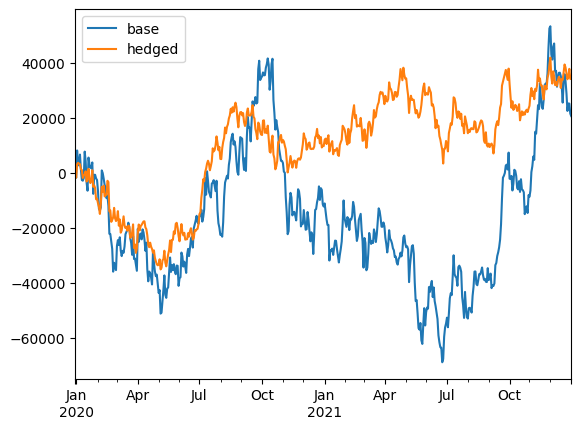

In [18]:
# Total PNL time series values
pd.DataFrame( {'base':base_test.strategy.values, 'hedged':hedge_test.strategy.values} ).plot()

<Axes: >

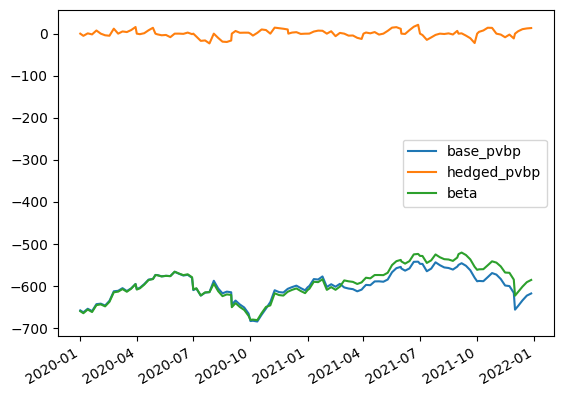

In [19]:
# Total risk time series values
pd.DataFrame(
    {
        "base_pvbp": base_test.strategy.risks["pvbp"],
        "hedged_pvbp": hedge_test.strategy.risks["pvbp"],
        "beta": hedge_test.strategy.risks["beta"],
    }
).dropna().plot()

<Axes: >

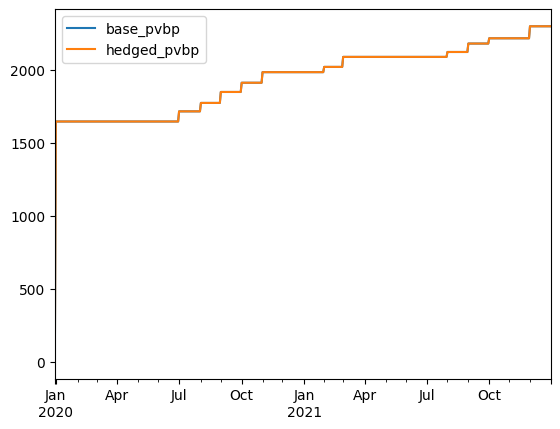

In [20]:
# Total bid/offer paid (same for both strategies)
# 거래 비용
pd.DataFrame(
    {
        "base_pvbp": base_test.strategy.bidoffers_paid,
        "hedged_pvbp": hedge_test.strategy.bidoffers_paid,
    }
).cumsum().dropna().plot()